In [ ]:
# Importing the google drive here
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
#vect = CountVectorizer()
path = "/content/drive/MyDrive/guvi/project-proposal/final-project/spam.csv"

## Reading the dataset using pandas. We drop the columns which are not required. (refer to Data Engineering module)

In [ ]:
# reading file using pandas
sms = pd.read_csv(path, encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploring the Data

In [ ]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

# Label Encoding
----------------
## While training or predicting the model, it is necessary to transform the data into a machine readable format. We now perform the relevant encoding to make it machine readable. (refer to module-11)

In [ ]:
# convert label to a numerical variable
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## Another special task is the feature engineering, where we try to find those features which can help us predict our label.

In [ ]:
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


## We plot the bar graph for the length of messages for each label. (please refer to the visualization module)

Text(0.5, 0, 'Message Length')

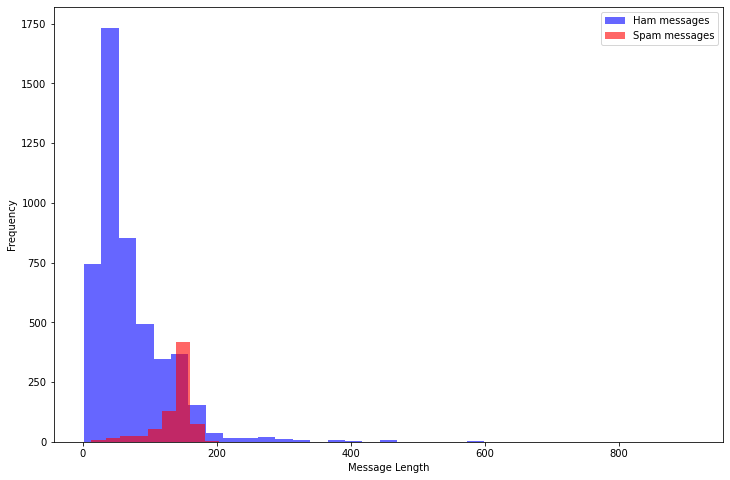

In [ ]:
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

## From the above plot, we observe that mostly the length of the spam messages are usually shorter than the ham messages. Can we use this knowledge to classify the spam?

In [ ]:
sms[sms.label=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.023627
std,0.0,58.016023
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,92.000000
max,0.0,910.000000


In [ ]:
sms[sms.label=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


## Our dataset consists short messages. We need to process the data such that we remove the irrelevant tokens (such as punctuations, stop words)

In [ ]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords') # Downloading the stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
sms['clean_msg'] = sms.message.apply(text_process)

In [ ]:
# This is our processed text
sms.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


## Creating the word count after removing stop words and punctuations. We need to represent each message as a vector so that we can perform the ML prediction. (Why?)

In [ ]:
from collections import Counter

words = sms[sms.label=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('get', 303), ('ltgt', 276), ('ok', 272), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224), ('good', 222), ('time', 189), ('day', 187), ('love', 185), ('going', 167), ('want', 163), ('one', 162), ('home', 160), ('lor', 160), ('need', 156), ('sorry', 153), ('still', 146), ('see', 137), ('n', 134), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 126), ('today', 125), ('send', 123), ('tell', 121), ('cant', 118), ('ì', 117), ('hi', 117), ('take', 112), ('much', 112), ('oh', 111), ('night', 107), ('hey', 106), ('happy', 105), ('great', 100), ('way', 100), ('hope', 99), ('pls', 98), ('work', 96), ('wat', 95), ('thats', 94), ('dear', 94)]


In [ ]:
words = sms[sms.label=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29)]


## Next we will create a vector notation for each message. For that we will use the Bag-of-Words approach that we learnt in Module-11 (data engineering). We will use SciKit Learn's CountVectorizer for that.

In [ ]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms.clean_msg
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [ ]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)
print(vect)

CountVectorizer()


In [ ]:
# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

In [ ]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [ ]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x7996 sparse matrix of type '<class 'numpy.float64'>'
	with 34796 stored elements in Compressed Sparse Row format>

## Building and evaluating the model

In [ ]:
# We will first use the Multinomial Naive Bayes model
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [ ]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 5.99 ms, sys: 846 µs, total: 6.84 ms
Wall time: 8.84 ms


MultinomialNB()

In [ ]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [ ]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9827709978463748

In [ ]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[1205,    8],
       [  16,  164]])

In [ ]:
# print message text for false positives (ham incorrectly classifier)
# X_test[(y_pred_class==1) & (y_test==0)]
X_test[y_pred_class > y_test]

2418    Madamregret disturbancemight receive reference...
4598                                laid airtel line rest
386                                   Customer place call
1289    HeyGreat dealFarm tour 9am 5pm 95pax 50 deposi...
5094    Hi ShanilRakhesh herethanksi exchanged uncut d...
494                                      free nowcan call
759     Call youcarlos isare phones vibrate acting mig...
3140                                  Customer place call
Name: clean_msg, dtype: object

In [ ]:
# print message text for false negatives (spam incorrectly classifier)
X_test[y_pred_class < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
3528    Xmas New Years Eve tickets sale club day 10am ...
3417    LIFE never much fun great came made truly spec...
2773    come takes little time child afraid dark becom...
1960    Guess Somebody know secretly fancies Wanna fin...
5       FreeMsg Hey darling 3 weeks word back Id like ...
2078                         85233 FREERingtoneReply REAL
1457    CLAIRE havin borin time alone wanna cum 2nite ...
190     unique enough Find 30th August wwwareyouunique...
2429    Guess IThis first time created web page WWWASJ...
3057    unsubscribed services Get tons sexy babes hunk...
1021    Guess Somebody know secretly fancies Wanna fin...
4067    TBSPERSOLVO chasing us since Sept forå£38 defi...
3358         Sorry missed call lets talk time 07090201529
2821    ROMCAPspam Everyone around responding well pre...
2247    Back work 2morro half term C 2nite sexy passio...
Name: clean_msg, dtype: object

In [ ]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9774342768159751

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model', MultinomialNB())])

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
pipe.predict(["you have won a prize"])

array([1])

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.9669777458722182

In [ ]:
metrics.confusion_matrix(y_test, y_pred)

array([[1213,    0],
       [  46,  134]])

In [ ]:
X_test

1078                                       Convey regards
4028                         Û anyway many good evenings
958     sort code acc bank natwest reply confirm ive s...
4642                                Sorry din lock keypad
4674    Hi babe Chloe r smashed saturday night great w...
                              ...                        
3207     Oops phone died didnt even know Yeah like better
4655                                 K Ill work something
1140                      Ohas usual vijay film different
1793                              bad girl still remember
1710        promises though havent even gotten dinner yet
Name: clean_msg, Length: 1393, dtype: object

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
import joblib
joblib.dump(pipe, '/content/drive/MyDrive/guvi/project-proposal/final-project/model.joblib')

['/content/drive/MyDrive/guvi/project-proposal/final-project/model.joblib']

In [ ]:
my_model = joblib.load('/content/drive/MyDrive/guvi/project-proposal/final-project/model.joblib')
my_model.predict(["You won a prize"])

array([1])